# Extract data

In [73]:
#pip install cssselect

In [74]:
import numpy as np 
import pandas as pd
import requests 
from bs4 import BeautifulSoup
import csv
from lxml import html
import re

## **Explanation of scraping tool**

In this section we will demonstrate our scraping tool and strategy by scraping data for one player. The process of scraping in the next section relies on using for loops to automate this process for many players.

The steps and tools we used for scraping are as follow:


First, We use the **request** library and the **get** function to get a response object (to grap the code of a page) and assign it to a variable 'page' and we will start with the clubs page:

In [75]:
page = requests.get('https://www.premierleague.com/clubs')

Second, we get the content of the response object using function **.content provided by Request library ('page.content')**
Then a document of this content is obtained using the **'fromstring'** function provided by **'html'** package of the **lxml** model
The result is stored in a variable 'tree'.

In [76]:
tree = html.fromstring(page.content)

Third, we used the **cssselect** method provided by **HTML** to locate and select elements and their childern from the 'tree' element we have gotten in the previous step.
for example if the elemnt we want to get is the link of a specific team from the clubs page, we use the cssselect on the class of teams which is on our case **'indexItem'**

Note: the class for each element can be obtained from the page by clikcing the right cursor of the mouse and choosing **inspect**, then we hover the mouse over the element to know its class    

In [77]:
linkLocation = tree.cssselect('.indexItem')[0].attrib['href']
linkLocation

'/clubs/1/Arsenal/overview'

Finally, this linklocation is added to the webpage link so we can get the total link of each team 

In [78]:
temp="http://www.premierleague.com/" + linkLocation
temp=temp.replace ("overview", "squad")
temp

'http://www.premierleague.com//clubs/1/Arsenal/squad'

The same approach is used to scrape players links from each team page, the difference is that the class of the playes is **'.playerOverviewCard'**

In [79]:
squadPage = requests.get(temp)
squadTree = html.fromstring(squadPage.content)
    
#Extracting players' links, they are under class 'playerOverviewCard'
playerLocation = squadTree.cssselect('.playerOverviewCard')[0].attrib['href']
print(playerLocation)
temp2="http://www.premierleague.com/" + playerLocation
temp2

/players/4985/Bernd-Leno/overview


'http://www.premierleague.com//players/4985/Bernd-Leno/overview'

Since we have the links of each player in the club we also use the same approach to get infomation on this player 
Class of Name:'div.name'
class of position: '.playerOverviewAside .info'


In [80]:
playerPage1 = requests.get(temp2)
playerTree1 = html.fromstring(playerPage1.content)
tempName = str(playerTree1.cssselect('div.name')[0].text_content())
print(tempName)
tempposition = str(playerTree1.cssselect('.playerOverviewAside .info')[1].text_content())
print(tempposition)


Bernd Leno
Goalkeeper


## **Teams' pages scraping**

In this section, we are scraping the pages for each team in Premier League. To do so , we will first access the page containing all clubs. Then , we will loop through all teams and save their links in a list so we can use them latter. In the clubs page, each team is represented by a link that takes you to the team page containing its stats and overview

In [81]:
#Take site and structure html
page = requests.get('https://www.premierleague.com/clubs')
tree = html.fromstring(page.content)

In [82]:
# extract link locations related to the teams contained in the page
linkLocation = tree.cssselect('.indexItem')

In [83]:
#Create an empty list for us to send each team's link to
teamLinks = []

# There are 20 teams, we will loop through them 
for i in range(0,20):
    
    # A variable that contains the ith team's link location
    temp = linkLocation[i].attrib['href']
    
    # To access the page of each team using the code i.e not manually, we will add the team's link to the website domain 
    temp = "http://www.premierleague.com/" + temp
    
    # When opening the team's page it will be the overview page, we will change it to squad since we are interested in players
    temp = temp.replace("overview", "squad")
    
    #Add the finished link to our teamLinks list
    teamLinks.append(temp)

## **Players' pages scraping**

In this section, we will use the links we have got for each team and we will make a list of similar links for all playeras in that team. This will help us scrape the information of each player later  

In [84]:
#Create empty lists for player links
#First list is used for links in the overview page of each player while the second is used for the stats page
#Each page contains information we will need for each player
playerLink1 = []
playerLink2 = []

#looping through teams using their links
for i in range(len(teamLinks)):
    
    #accessing each team page 
    squadPage = requests.get(teamLinks[i])
    squadTree = html.fromstring(squadPage.content)
    
    #Extracting players' links, they are under class 'playerOverviewCard'
    playerLocation = squadTree.cssselect('.playerOverviewCard')

    #loop through players links in order to add them to the website domain. This eliminates the need for accessing each players page manually
    for i in range(len(playerLocation)):
        
        # add the link to the website domain 
        playerLink1.append("http://www.premierleague.com/" + playerLocation[i].attrib['href'])
        
        


In [85]:
for i in range(len(playerLink1)):
    temp=playerLink1[i].replace("overview", "stats")
    playerLink2.append(playerLink1[i].replace("overview", "stats"))

In [86]:
#Create lists for each variable
Name = []
Team = []
Age = []
Apps = []
HeightCM = []
WeightKG = []
Goals= []
Assists=[]
Passes=[]
Wins=[]
Losses=[]
Yellowcards=[]
Redcards=[]
Fouls=[]
Position=[]

In [87]:
for i in range(len(playerLink1)):

    #...download and process the two pages collected earlier...
    playerPage1 = requests.get(playerLink1[i])
    playerTree1 = html.fromstring(playerPage1.content)
    playerPage2 = requests.get(playerLink2[i])
    playerTree2 = html.fromstring(playerPage2.content)

    #...find the relevant datapoint for each player, starting with name...
    tempName = str(playerTree1.cssselect('div.name')[0].text_content())
    #print(tempName)
    
    #...and team, but if there isn't a team, return "BLANK"...
    try:
        tempTeam = str(playerTree1.cssselect('.table:nth-child(1) .long')[0].text_content())
    except IndexError:
        tempTeam = str("BLANK")
    #print(tempTeam)
    
    #...and age, but if this isn't there, leave a blank 'no number' number...
    try:  
        tempAge = playerTree1.cssselect('.pdcol2 li:nth-child(1) .info--light')[0].text_content()
        res= tempAge[tempAge.find("(")+1:tempAge.find(")")]
        #res = re.findall(r"\(\s*\+?(-?\d+)\s*\)", tempAge)
    except IndexError:
        tempAge = float('NaN')
    #print(res) 

    #...and appearances. This is a bit of a mess on the page, so tidy it first...
    try:
        tempApps = playerTree2.cssselect('.statappearances')[0].text_content()
        tempApps = int(re.search(r'\d+', tempApps).group())
    except IndexError:
        tempApps = float('NaN')
        

    #...and height. Needs tidying again...
    try:
        tempHeight = playerTree1.cssselect('.pdcol3 li:nth-child(1) .info')[0].text_content()
        tempHeight = int(re.search(r'\d+', tempHeight).group())
    except IndexError:
        tempHeight = float('NaN')

    #...and weight. Same with tidying and returning blanks if it isn't there
    try:
        tempWeight = playerTree1.cssselect('.pdcol3 li+ li .info')[0].text_content()
        tempWeight = int(re.search(r'\d+', tempWeight).group())
    except IndexError:
        tempWeight = float('NaN')
    
    try:
        tempgoals =  playerTree2.cssselect('.statgoals')[0].text_content()
        tempgoals = int(re.search(r'\d+', tempgoals).group())
    except IndexError:
        tempgoals = float('NaN')
    #print(tempgoals)
    
    try:
        tempassists =  playerTree2.cssselect('.statgoal_assist')[0].text_content()
        tempassists = int(re.search(r'\d+', tempassists).group())
    except IndexError:
        tempassists = float('NaN')
    #print(tempassists)
    
    try:
        tempapasses =  playerTree2.cssselect('.stattotal_pass')[0].text_content()
        res2=tempapasses.replace(",", "")
        tempapasses = int(re.search(r'\d+', res2).group())
        
    except IndexError:
        tempapasses = float('NaN')
    #print(tempapasses)
    
    
    try:
        tempwins = playerTree2.cssselect('.statwins')[0].text_content()
        tempwins = int(re.search(r'\d+', tempwins).group())
    except IndexError:
        tempwins = float('NaN')
    
    try:
        templosses = playerTree2.cssselect('.statlosses')[0].text_content()
        templosses = int(re.search(r'\d+', templosses).group())
    except IndexError:
        templosses = float('NaN')
        
    try:
        tempYellowcards = playerTree2.cssselect('.statyellow_card')[0].text_content()
        tempYellowcards = int(re.search(r'\d+', tempYellowcards).group())
    except IndexError:
        tempYellowcards = float('NaN')
        
    try:
        tempRedcards = playerTree2.cssselect('.statred_card')[0].text_content()
        tempRedcards = int(re.search(r'\d+', tempRedcards).group())
    except IndexError:
        tempRedcards = float('NaN')
        
    try:
        tempFouls = playerTree2.cssselect('.statfouls')[0].text_content()
        tempFouls = int(re.search(r'\d+', tempFouls).group())
    except IndexError:
        tempFouls = float('NaN')     
        
    try:
        tempposition = str(playerTree1.cssselect('.playerOverviewAside .info')[1].text_content())
    except IndexError:
        tempposition = str("BLANK")
    #print(tempposition)
    
    #Now that we have a player's full details - add them all to the lists
    
    Name.append(tempName)
    Team.append(tempTeam)
    Age.append(res)
    Apps.append(tempApps)
    HeightCM.append(tempHeight)
    WeightKG.append(tempWeight)
    Goals.append(tempgoals)
    Assists.append(tempassists)
    Passes.append(tempapasses)
    Wins.append(tempwins)
    Losses.append(templosses)
    Yellowcards.append(tempYellowcards)
    Redcards.append(tempRedcards)
    Fouls.append(tempFouls)
    Position.append(tempposition)

In [88]:
#Create data frame from lists
df = pd.DataFrame(
    {'Name':Name,
     'Team':Team,
     'Position':Position,
     'Age':Age,
     'Apps':Apps,
     'HeightCM':HeightCM,
     'WeightKG':WeightKG,
    'Goals':Goals,
    'Assists':Assists,
    'Passes':Passes,
     'Wins':Wins,
      'Losses':Losses,
   'Yellowcards':Yellowcards,
    'Redcards':Redcards,
    'Fouls':Fouls})

#Show me the top 20 rows:

df.head(20)

,Name,Team,Position,Age,Apps,HeightCM,WeightKG,Goals,Assists,Passes,Wins,Losses,Yellowcards,Redcards,Fouls
0,Bernd Leno,Arsenal,Goalkeeper,29,96,190.0,83.0,0,0,2689,42,28,2,1,2
1,RÃºnar Alex RÃºnarsson,Arsenal,Goalkeeper,26,1,186.0,76.0,0,0,9,0,1,0,0,0
2,Karl Hein,Arsenal,Goalkeeper,19,0,193.0,NaN,0,0,0,0,0,0,0,0
3,Mat Ryan,Arsenal (Loan),Goalkeeper,29,124,184.0,82.0,0,0,3596,29,55,3,0,2
4,Arthur Okonkwo,Arsenal,Goalkeeper,19,0,NaN,NaN,0,0,0,0,0,0,0,0
5,James Hillson,Arsenal,Goalkeeper,20,0,NaN,NaN,0,0,0,0,0,0,0,0
6,HÃ©ctor BellerÃ­n,Arsenal,Defender,26,183,178.0,74.0,8,20,8141,99,47,30,0,143
7,Kieran Tierney,Arsenal,Defender,23,41,178.0,70.0,2,4,1590,18,15,6,0,22
8,Rob Holding,Arsenal,Defender,25,68,189.0,75.0,0,1,3770,36,20,10,0,52
9,Calum Chambers,Arsenal,Defender,26,148,182.0,66.0,6,4,6353,52,59,28,1,144


In [89]:
df.shape

(651, 15)

In [90]:
df.to_csv('Teams_data.csv' ,index=False )

# Pre-processing

In [91]:
df = pd.read_csv('Teams_data.csv')

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651 entries, 0 to 650
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         651 non-null    object 
 1   Team         651 non-null    object 
 2   Position     651 non-null    object 
 3   Age          651 non-null    int64  
 4   Apps         651 non-null    int64  
 5   HeightCM     506 non-null    float64
 6   WeightKG     482 non-null    float64
 7   Goals        651 non-null    int64  
 8   Assists      651 non-null    int64  
 9   Passes       651 non-null    int64  
 10  Wins         651 non-null    int64  
 11  Losses       651 non-null    int64  
 12  Yellowcards  651 non-null    int64  
 13  Redcards     651 non-null    int64  
 14  Fouls        651 non-null    int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 76.4+ KB


In [93]:
#cheking for null values
df.isnull().sum()

Name             0
Team             0
Position         0
Age              0
Apps             0
HeightCM       145
WeightKG       169
Goals            0
Assists          0
Passes           0
Wins             0
Losses           0
Yellowcards      0
Redcards         0
Fouls            0
dtype: int64

In [94]:
df=df[df['Apps']!=0]
df.reset_index(drop=True, inplace=True  )

In [95]:
df.isnull().sum()

Name            0
Team            0
Position        0
Age             0
Apps            0
HeightCM       50
WeightKG       63
Goals           0
Assists         0
Passes          0
Wins            0
Losses          0
Yellowcards     0
Redcards        0
Fouls           0
dtype: int64

We have a missing data in HeightCM and WeightKG columns. So, we will fill them with the average height and weight for the players in the same age.

In [96]:
# group the players by age
group = df[['HeightCM' ,'WeightKG' ,'Age']].groupby('Age').mean()
# fill the null values with the mean 
for i , r in df[df['HeightCM'].isnull()].iterrows():
    age = df.iloc[i,3]
    df.iloc[i,5] = group.loc[age , 'HeightCM']
    
for i , r in df[df['WeightKG'].isnull()].iterrows():
    age = df.iloc[i,3]
    df.iloc[i,6] = group.loc[age , 'WeightKG']
df.isnull().sum()

Name           0
Team           0
Position       0
Age            0
Apps           0
HeightCM       0
WeightKG       0
Goals          0
Assists        0
Passes         0
Wins           0
Losses         0
Yellowcards    0
Redcards       0
Fouls          0
dtype: int64

In [97]:
#creating new columns

df['Wins_ratio'] = df['Wins'] / df['Apps']

df['Goals_ratio'] = df['Goals'] / df['Apps']
    

df['Yellowcardsd_ratio'] = df['Yellowcards'] / df['Apps']

    
df['Fouls_ratio'] = df['Fouls'] / df['Apps']

    

df['Passes_ratio'] = df['Passes'] / df['Apps']
  

In [98]:
df.head()

,Name,Team,Position,Age,Apps,HeightCM,WeightKG,Goals,Assists,Passes,Wins,Losses,Yellowcards,Redcards,Fouls,Wins_ratio,Goals_ratio,Yellowcardsd_ratio,Fouls_ratio,Passes_ratio
0,Bernd Leno,Arsenal,Goalkeeper,29,96,190.0,83.0,0,0,2689,42,28,2,1,2,0.437500,0.000000,0.020833,0.020833,28.010417
1,RÃºnar Alex RÃºnarsson,Arsenal,Goalkeeper,26,1,186.0,76.0,0,0,9,0,1,0,0,0,0.000000,0.000000,0.000000,0.000000,9.000000
2,Mat Ryan,Arsenal (Loan),Goalkeeper,29,124,184.0,82.0,0,0,3596,29,55,3,0,2,0.233871,0.000000,0.024194,0.016129,29.000000
3,HÃ©ctor BellerÃ­n,Arsenal,Defender,26,183,178.0,74.0,8,20,8141,99,47,30,0,143,0.540984,0.043716,0.163934,0.781421,44.486339
4,Kieran Tierney,Arsenal,Defender,23,41,178.0,70.0,2,4,1590,18,15,6,0,22,0.439024,0.048780,0.146341,0.536585,38.780488


In [99]:
# for further work we will need some columns to be descritisized, in this section we add descritisized columns to the data
# descritizing of some columns
df['Ycards_ratio_dicretized']=pd.qcut(df['Yellowcardsd_ratio'],3, labels=['Low','Medium','High'])
df['Fouls_ratio_dicretized']=pd.qcut(df['Fouls_ratio'],3, labels=['Low','Medium','High'])

In [100]:
df.head()

,Name,Team,Position,Age,Apps,HeightCM,WeightKG,Goals,Assists,Passes,...,Yellowcards,Redcards,Fouls,Wins_ratio,Goals_ratio,Yellowcardsd_ratio,Fouls_ratio,Passes_ratio,Ycards_ratio_dicretized,Fouls_ratio_dicretized
0,Bernd Leno,Arsenal,Goalkeeper,29,96,190.0,83.0,0,0,2689,...,2,1,2,0.437500,0.000000,0.020833,0.020833,28.010417,Low,Low
1,RÃºnar Alex RÃºnarsson,Arsenal,Goalkeeper,26,1,186.0,76.0,0,0,9,...,0,0,0,0.000000,0.000000,0.000000,0.000000,9.000000,Low,Low
2,Mat Ryan,Arsenal (Loan),Goalkeeper,29,124,184.0,82.0,0,0,3596,...,3,0,2,0.233871,0.000000,0.024194,0.016129,29.000000,Low,Low
3,HÃ©ctor BellerÃ­n,Arsenal,Defender,26,183,178.0,74.0,8,20,8141,...,30,0,143,0.540984,0.043716,0.163934,0.781421,44.486339,High,Medium
4,Kieran Tierney,Arsenal,Defender,23,41,178.0,70.0,2,4,1590,...,6,0,22,0.439024,0.048780,0.146341,0.536585,38.780488,High,Low


In [101]:
df.describe() # statical sammary

,Age,Apps,HeightCM,WeightKG,Goals,Assists,Passes,Wins,Losses,Yellowcards,Redcards,Fouls,Wins_ratio,Goals_ratio,Yellowcardsd_ratio,Fouls_ratio,Passes_ratio
count,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000
mean,26.509653,90.372587,182.284559,75.895602,9.532819,6.729730,3055.635135,37.380309,31.940154,10.096525,0.395753,69.723938,0.376618,0.079831,0.101292,0.706265,30.495165
std,4.479796,86.537266,6.773270,7.445156,19.148455,10.809424,3396.175556,41.913009,30.181628,12.478467,0.779166,81.581675,0.188326,0.107823,0.088151,0.415093,16.148769
min,17.000000,1.000000,163.000000,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,26.000000,178.000000,70.000000,0.000000,0.000000,631.750000,7.250000,9.000000,2.000000,0.000000,12.250000,0.269339,0.000000,0.037037,0.469062,19.371779
50%,27.000000,62.000000,182.000000,75.000000,2.000000,2.000000,1843.500000,21.000000,21.500000,5.500000,0.000000,40.000000,0.363917,0.040956,0.093966,0.714286,28.904634
75%,30.000000,139.000000,188.000000,80.000000,9.000000,8.000000,4480.000000,53.000000,45.000000,14.000000,1.000000,100.500000,0.493767,0.111111,0.148936,0.960516,40.481241
max,39.000000,563.000000,201.000000,101.000000,182.000000,85.000000,19662.000000,283.000000,163.000000,82.000000,5.000000,456.000000,1.000000,0.676230,1.000000,2.000000,84.863636


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Name                     518 non-null    object  
 1   Team                     518 non-null    object  
 2   Position                 518 non-null    object  
 3   Age                      518 non-null    int64   
 4   Apps                     518 non-null    int64   
 5   HeightCM                 518 non-null    float64 
 6   WeightKG                 518 non-null    float64 
 7   Goals                    518 non-null    int64   
 8   Assists                  518 non-null    int64   
 9   Passes                   518 non-null    int64   
 10  Wins                     518 non-null    int64   
 11  Losses                   518 non-null    int64   
 12  Yellowcards              518 non-null    int64   
 13  Redcards                 518 non-null    int64   
 14  Fouls     

Now let's see how many teams we have and how many players they contain

In [103]:
df['Team'].value_counts()

Sheffield United                    29
Manchester United                   28
Newcastle United                    27
Leicester City                      26
Burnley                             26
Aston Villa                         26
Liverpool                           26
Everton                             24
Crystal Palace                      24
Chelsea                             23
Leeds United                        23
Tottenham Hotspur                   23
Brighton and Hove Albion            23
Manchester City                     23
Southampton                         22
Arsenal                             22
West Bromwich Albion                21
Wolverhampton Wanderers             20
Fulham                              18
West Ham United                     18
Fulham  (Loan)                       7
West Bromwich Albion  (Loan)         4
Arsenal  (Loan)                      3
West Ham United U21                  3
Wolverhampton Wanderers  (Loan)      3
Chelsea U21              

We now will clean the teams names

In [104]:
# remove '(Loan)' and ' U21' from teams name
# substitute & to and
df['Team'] = df['Team'].apply(lambda x : re.sub("\(Loan\)|U21",' ' ,x).strip())
df['Team'] = df['Team'].apply(lambda x : re.sub("&",'and' ,x))

In [105]:
df['Team'].value_counts()

Sheffield United            30
Manchester United           29
Newcastle United            28
Leicester City              27
Liverpool                   27
Aston Villa                 27
Burnley                     26
Fulham                      26
Crystal Palace              26
West Bromwich Albion        25
Southampton                 25
Chelsea                     25
Tottenham Hotspur           25
Leeds United                25
Manchester City             25
Everton                     25
Arsenal                     25
Brighton and Hove Albion    24
Wolverhampton Wanderers     24
West Ham United             23
Lech Poznan                  1
Name: Team, dtype: int64

There is still one team with one player so we will drop it 

In [106]:
df = df.drop(index = 395).reset_index()
df['Team'].value_counts()

Sheffield United            30
Manchester United           29
Newcastle United            28
Leicester City              27
Liverpool                   27
Aston Villa                 27
Burnley                     26
Crystal Palace              26
Fulham                      26
Leeds United                25
Chelsea                     25
West Bromwich Albion        25
Tottenham Hotspur           25
Manchester City             25
Everton                     25
Arsenal                     25
Brighton and Hove Albion    24
Wolverhampton Wanderers     24
Southampton                 24
West Ham United             23
Lech Poznan                  1
Name: Team, dtype: int64

In [107]:
df.to_csv('processing_Teams_data.csv' ,index=False )

# Analysis

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

In [109]:
df = pd.read_csv('processing_Teams_data.csv')

In [110]:
df.head()

,index,Name,Team,Position,Age,Apps,HeightCM,WeightKG,Goals,Assists,...,Yellowcards,Redcards,Fouls,Wins_ratio,Goals_ratio,Yellowcardsd_ratio,Fouls_ratio,Passes_ratio,Ycards_ratio_dicretized,Fouls_ratio_dicretized
0,0,Bernd Leno,Arsenal,Goalkeeper,29,96,190.0,83.0,0,0,...,2,1,2,0.437500,0.000000,0.020833,0.020833,28.010417,Low,Low
1,1,RÃºnar Alex RÃºnarsson,Arsenal,Goalkeeper,26,1,186.0,76.0,0,0,...,0,0,0,0.000000,0.000000,0.000000,0.000000,9.000000,Low,Low
2,2,Mat Ryan,Arsenal,Goalkeeper,29,124,184.0,82.0,0,0,...,3,0,2,0.233871,0.000000,0.024194,0.016129,29.000000,Low,Low
3,3,HÃ©ctor BellerÃ­n,Arsenal,Defender,26,183,178.0,74.0,8,20,...,30,0,143,0.540984,0.043716,0.163934,0.781421,44.486339,High,Medium
4,4,Kieran Tierney,Arsenal,Defender,23,41,178.0,70.0,2,4,...,6,0,22,0.439024,0.048780,0.146341,0.536585,38.780488,High,Low


check for normality useing Probability-plot

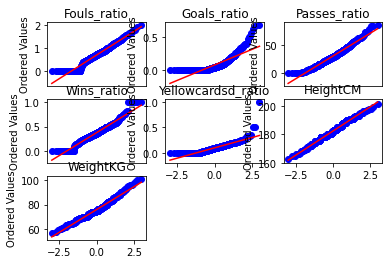

In [111]:
plt.subplot(3,3,1)
#Fouls
data = df['Fouls_ratio'].values
stats.probplot(data , plot =plt)
plt.title('Fouls_ratio')
plt.xlabel(' ')
plt.xticks([])

plt.subplot(3,3,2)
#Goals
data = df['Goals_ratio'].values
stats.probplot(data , plot =plt)
plt.title('Goals_ratio')
plt.xlabel(' ')
plt.xticks([])

plt.subplot(3,3,3)
#Passes
data = df['Passes_ratio'].values
stats.probplot(data , plot =plt)
plt.title('Passes_ratio')
plt.xlabel(' ')
plt.xticks([])

plt.subplot(3,3,4)
#Wins
data = df['Wins_ratio'].values
stats.probplot(data , plot =plt)
plt.title('Wins_ratio')
plt.xlabel(' ')
plt.xticks([])


plt.subplot(3,3,5)
#Yellowcards
data = df['Yellowcardsd_ratio'].values
stats.probplot(data , plot =plt)
plt.title('Yellowcardsd_ratio')
plt.xlabel(' ')

plt.subplot(3,3,6)
#HeightCM
data = df['HeightCM'].values
stats.probplot(data , plot =plt)
plt.title('HeightCM')
plt.xlabel(' ')

plt.subplot(3,3,7)
#WeightKG
data = df['WeightKG'].values
stats.probplot(data , plot =plt)
plt.title('WeightKG')
plt.xlabel(' ')

plt.rcParams["figure.figsize"] = (15,10)
plt.show()

### check for normality useing D’Agostino–Pearson omnibus test

In [112]:
print(stats.normaltest(df['WeightKG'].values))
print(stats.normaltest(df['HeightCM'].values))
print(stats.normaltest(df['Fouls_ratio'].values))
print(stats.normaltest(df['Goals_ratio'].values))
print(stats.normaltest(df['Passes_ratio'].values))
print(stats.normaltest(df['Wins_ratio'].values))
print(stats.normaltest(df['Yellowcardsd_ratio'].values))

NormaltestResult(statistic=22.502082130727228, pvalue=1.2993763253326077e-05)
NormaltestResult(statistic=2.686320985824575, pvalue=0.26101941357497754)
NormaltestResult(statistic=1.0197814019362024, pvalue=0.600561215984664)
NormaltestResult(statistic=253.2031502370201, pvalue=1.0414406512339953e-55)
NormaltestResult(statistic=21.093840309189435, pvalue=2.6274277095531704e-05)
NormaltestResult(statistic=28.60978868433108, pvalue=6.130040205849619e-07)
NormaltestResult(statistic=364.25505863133543, pvalue=7.998692764224537e-80)


From the first figur we can notice that Passes_ratio, WeightKG and HeightCM are somehow fitting the line but after the D’Agostino–Pearson omnibus test it turns out that both of HeightCM and Fouls_ratio are the data with normal distribution

---------------------------------------

C:\Users\Anbara\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Anbara\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


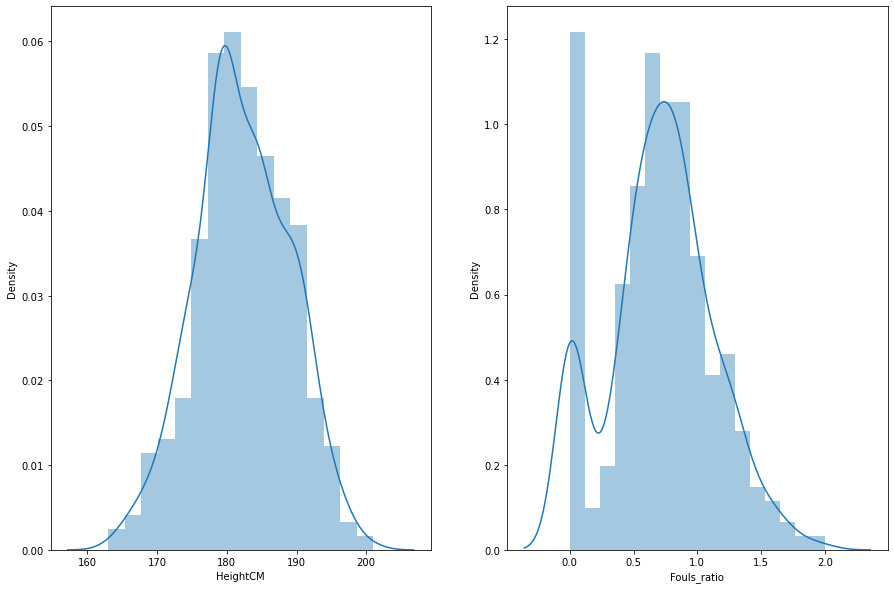

In [113]:
plt.subplot(1,2,1)
sns.distplot(df['HeightCM'], hist=True, kde=True)

plt.subplot(1,2,2)
sns.distplot(df['Fouls_ratio'], hist=True, kde=True)
plt.show()

___________________________________

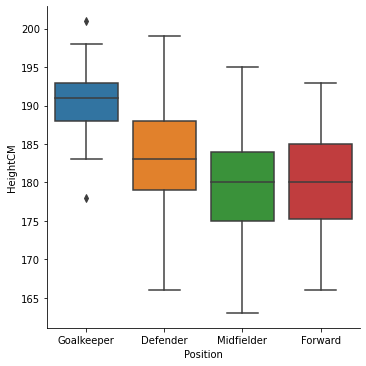

In [114]:
#plot the distribution of Height for each Positon
sns.catplot(x="Position", y="HeightCM", kind="box", data=df)
plt.show()

We can see that the mean of heights for defender, midfielder and forward are close to each other. In other hand for players in goalkeeper position the average is higher than hights for other positions.

______________________

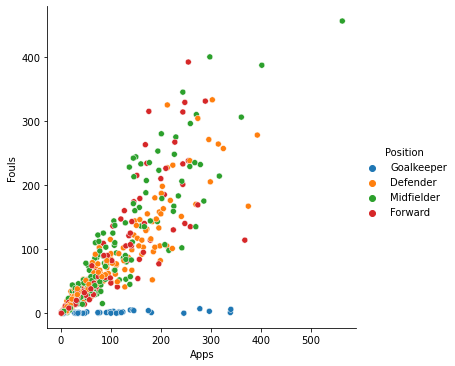

In [115]:
sns.relplot(x="Apps", y="Fouls",hue='Position' ,data=df)
plt.show()

There seems to be a positive correlatoin between the number of apps and the number of fouls commited by players in each position. The only exception for this relation is for the apps of goal keepers and their commited fouls. It is obvious that the number of fouls committed by goal keeper is low regardless of the number of games they have played. This could be attributed to the fact that goal keepers usually have less contact with other players.

________________

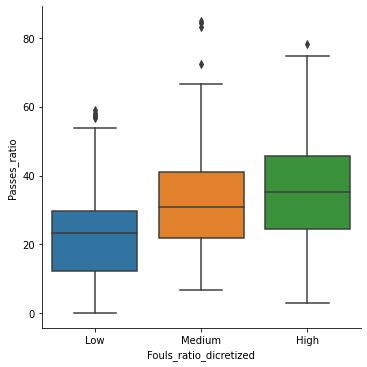

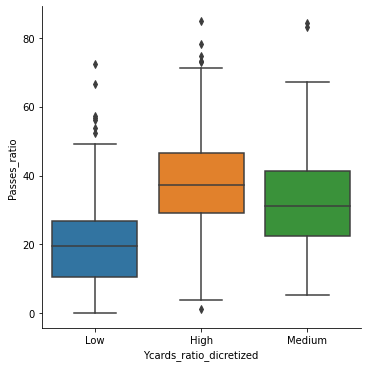

In [116]:
#plt.subplot(1,2,1)
sns.catplot(x="Fouls_ratio_dicretized", y="Passes_ratio", kind="box", data=df)
#plt.subplot(1,2,2)
sns.catplot(x="Ycards_ratio_dicretized", y="Passes_ratio", kind="box", data=df)
plt.show()


____________

Now we will create new table grouped by teams contain the total of red cards and the total of yellow cards

In [117]:
Team = df[[ 'Redcards','Yellowcards' ,'Team']].groupby('Team').agg(sum)
Team.head()

,Redcards,Yellowcards
Team,,
Arsenal,15,259
Aston Villa,6,174
Brighton and Hove Albion,8,147
Burnley,6,432
Chelsea,8,214


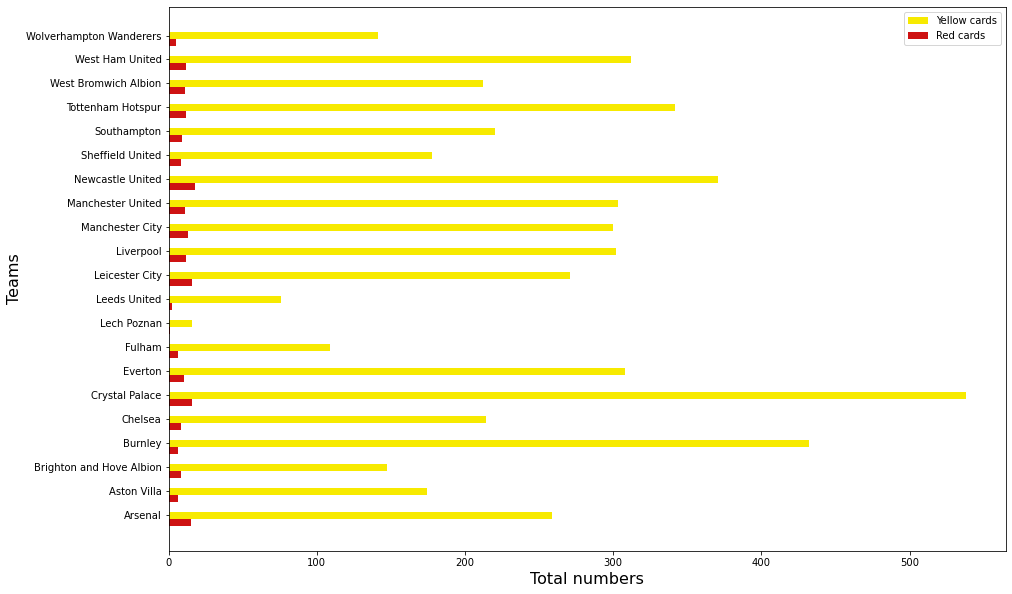

In [118]:
x = np.arange(len(Team))
width = 0.3
plt.barh(x , Team['Yellowcards'],width, color = '#f7ea00' )
plt.barh(x-0.3 ,Team['Redcards'],width , color='#ce1212')

plt.yticks(x, Team.index)
plt.legend(["Yellow cards", "Red cards"])
plt.xlabel('Total numbers',fontsize=16)
plt.ylabel('Teams',fontsize=16)
plt.show()

# Type of study

Our case study is :
- **Observational study**; because we collected information, but did not interact with the study population (players) and without trying to affect them.

- **Retrospective study**; because we took our data from previous matches since 2015 up to this season of Premier league.

- **longitudinal investigations**; we have collected information(Apps, Goals, Fouls, wins,passes,..etc) over a period of time for 6 seasons(2015-2021), multiple times from each player.

- **Case-Control**; in our study we evaluated the teams based on certain criteria. The top four in the Premier League qualify for the Champions League group stages - plus the winners of the Champions League and Europa League, there can be a maximum of five English teams in the Champions League.


# Hypothesis Testing

In Premier league when a club wants to loan a new goalkeeper they have to put into consideration different things, depending on goalkeepers posture their heights have to be higher from others in the same team.

For each 20 team in Premier League there are 4 positions : **goalkeeper, defender, midfielder and forward**.The average amount of players' height is different from position to another as shown in the figure below. The mean for goalkeepers is 190.666667. Is this difference significant? Test at the 5% level of significance.
 

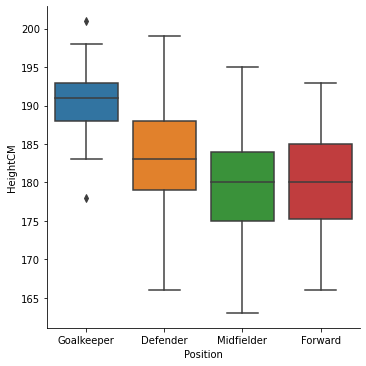

In [119]:
#plot the distribution of Height for each Position
sns.catplot(x="Position", y="HeightCM", kind="box", data=df)
plt.show()

$H_0: \mu_1 = \mu_2  $ 

$H_1: \mu_1 \neq \mu_2 $

In [120]:
df.describe()

,index,Age,Apps,HeightCM,WeightKG,Goals,Assists,Passes,Wins,Losses,Yellowcards,Redcards,Fouls,Wins_ratio,Goals_ratio,Yellowcardsd_ratio,Fouls_ratio,Passes_ratio
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,258.235977,26.500967,90.309478,182.263833,75.889598,9.551257,6.742747,3055.411992,37.386847,31.895551,10.106383,0.396518,69.856867,0.376812,0.079985,0.101409,0.707616,30.504284
std,149.702167,4.479767,86.609147,6.763368,7.451112,19.162397,10.815828,3399.461030,41.953339,30.193766,12.488533,0.779726,81.604518,0.188456,0.107870,0.088196,0.414354,16.163074
min,0.000000,17.000000,1.000000,163.000000,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,129.000000,23.000000,26.000000,178.000000,70.000000,0.000000,0.000000,629.000000,7.000000,9.000000,2.000000,0.000000,13.000000,0.269231,0.000000,0.037037,0.470000,19.360784
50%,258.000000,27.000000,62.000000,182.000000,75.000000,2.000000,2.000000,1820.000000,21.000000,21.000000,6.000000,0.000000,40.000000,0.364198,0.041096,0.094183,0.714286,28.965517
75%,387.000000,30.000000,139.000000,188.000000,80.000000,9.000000,8.000000,4481.000000,53.000000,45.000000,14.000000,1.000000,101.000000,0.494253,0.111111,0.148936,0.961538,40.493506
max,517.000000,39.000000,563.000000,201.000000,101.000000,182.000000,85.000000,19662.000000,283.000000,163.000000,82.000000,5.000000,456.000000,1.000000,0.676230,1.000000,2.000000,84.863636


In [121]:
df.loc[df.Position == "Goalkeeper"].describe()

,index,Age,Apps,HeightCM,WeightKG,Goals,Assists,Passes,Wins,Losses,Yellowcards,Redcards,Fouls,Wins_ratio,Goals_ratio,Yellowcardsd_ratio,Fouls_ratio,Passes_ratio
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,234.823529,30.019608,79.803922,190.666667,83.658348,0.019608,0.215686,2030.627451,33.529412,27.882353,2.352941,0.156863,1.176471,0.358335,0.000198,0.029143,0.030288,25.087422
std,147.791976,4.545284,90.288874,4.226898,6.176912,0.140028,0.540878,2197.157527,45.448588,29.622726,2.784410,0.418213,1.728651,0.209640,0.001414,0.038171,0.139355,5.033136
min,0.000000,21.000000,1.000000,178.000000,73.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000
25%,116.500000,27.000000,5.000000,188.000000,80.000000,0.000000,0.000000,123.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.264450,0.000000,0.000000,0.000000,23.741304
50%,230.000000,30.000000,44.000000,191.000000,84.000000,0.000000,0.000000,1140.000000,17.000000,18.000000,1.000000,0.000000,0.000000,0.361905,0.000000,0.020833,0.000000,25.909091
75%,337.500000,34.000000,115.500000,193.000000,87.000000,0.000000,0.000000,2802.500000,42.000000,43.500000,4.000000,0.000000,2.000000,0.498529,0.000000,0.042100,0.020518,28.187271
max,495.000000,39.000000,340.000000,201.000000,98.000000,1.000000,2.000000,7522.000000,186.000000,112.000000,11.000000,2.000000,7.000000,1.000000,0.010101,0.200000,1.000000,36.038462


In [122]:
data1 = df.loc[df.Position == "Goalkeeper"]["HeightCM"].values
data2 = df.loc[df.Position != "Goalkeeper"]["HeightCM"].values

ttest, pVal = stats.ttest_ind(data1,data2)

if pVal < 0.05:
    print("Mean of Goalkeepers' height is significantly different from the mean of other positions' height")
    print(' p value ={0} '.format(pVal))

Mean of Goalkeepers' height is significantly different from the mean of other positions' height
 p value =1.5487737441784005e-22 


#### So the p-value was less than alpha which means we have to reject the null hypothesis..